In [2]:
import boto3
import sagemaker
from sagemaker.session import s3_input,Session


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
bucket_name = 'sageiot' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
my_region = boto3.session.Session().region_name # set the region of the instance
print(my_region)

us-east-1


In [4]:
# set an output path where the trained model will be saved
prefix = 'xgboost-as-a-built-in-algo'
output_path ='s3://{}/{}/output'.format(bucket_name, prefix)
print(output_path)

s3://sageiot/xgboost-as-a-built-in-algo/output


In [5]:
import pandas as pd
import boto3

In [6]:
excel_filename = 'dynamodb_updated.xlsx'
df = pd.read_excel(excel_filename)

In [7]:
print("Loaded data from Excel:")
print(df)



Loaded data from Excel:
      humidity  distance  temperature             timestamp
0           69    13.226    30.799999  1970-01-01T05:30:03Z
1           69    13.685    30.799999  1970-01-01T05:30:04Z
2           50    12.835    37.299999  1970-01-01T05:30:11Z
3           51     3.689    35.000000  2024-05-01T14:20:06Z
4           51     3.281    35.000000  2024-05-01T14:20:07Z
...        ...       ...          ...                   ...
1906        61     4.335    32.599998  2024-05-18T15:06:34Z
1907        61     4.335    32.599998  2024-05-18T15:06:39Z
1908        61     4.335    32.599998  2024-05-18T15:06:44Z
1909        61     4.335    32.599998  2024-05-18T15:06:49Z
1910        61     4.335    32.599998  2024-05-18T15:06:54Z

[1911 rows x 4 columns]


# Approach 1

In [8]:
df_og=df
df_og.head()

,humidity,distance,temperature,timestamp
0,69,13.226,30.799999,1970-01-01T05:30:03Z
1,69,13.685,30.799999,1970-01-01T05:30:04Z
2,50,12.835,37.299999,1970-01-01T05:30:11Z
3,51,3.689,35.000000,2024-05-01T14:20:06Z
4,51,3.281,35.000000,2024-05-01T14:20:07Z


In [9]:
df_og['timestamp'] = pd.to_datetime(df_og['timestamp'])
df_og = df_og[df_og['timestamp'].dt.year != 1970]
df_og.set_index('timestamp', inplace=True)
df_og.head()


,humidity,distance,temperature
timestamp,,,
2024-05-01 14:20:06+00:00,51,3.689,35.0
2024-05-01 14:20:07+00:00,51,3.281,35.0
2024-05-01 14:20:08+00:00,51,4.573,35.0
2024-05-01 14:20:09+00:00,51,4.573,35.0
2024-05-01 14:20:10+00:00,51,3.264,35.0


In [10]:
df_og = df_og.sort_values(by='timestamp')
df_og.head()


,humidity,distance,temperature
timestamp,,,
2024-05-01 14:20:06+00:00,51,3.689,35.0
2024-05-01 14:20:07+00:00,51,3.281,35.0
2024-05-01 14:20:08+00:00,51,4.573,35.0
2024-05-01 14:20:09+00:00,51,4.573,35.0
2024-05-01 14:20:10+00:00,51,3.264,35.0


In [11]:
df_og

,humidity,distance,temperature
timestamp,,,
2024-05-01 14:20:06+00:00,51,3.689,35.000000
2024-05-01 14:20:07+00:00,51,3.281,35.000000
2024-05-01 14:20:08+00:00,51,4.573,35.000000
2024-05-01 14:20:09+00:00,51,4.573,35.000000
2024-05-01 14:20:10+00:00,51,3.264,35.000000
...,...,...,...
2024-05-18 15:06:34+00:00,61,4.335,32.599998
2024-05-18 15:06:39+00:00,61,4.335,32.599998
2024-05-18 15:06:44+00:00,61,4.335,32.599998


In [12]:
df_resampled = df_og.resample('30s').mean()
df_resampled = df_resampled.fillna(method='ffill')
df_resampled.tail()

/tmp/ipykernel_3920/1095693760.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_resampled = df_resampled.fillna(method='ffill')


,humidity,distance,temperature
timestamp,,,
2024-05-18 15:04:30+00:00,59.833333,4.267,32.900002
2024-05-18 15:05:00+00:00,60.000000,4.063,32.799999
2024-05-18 15:05:30+00:00,60.833333,4.131,32.799999
2024-05-18 15:06:00+00:00,60.500000,4.131,32.666667
2024-05-18 15:06:30+00:00,61.000000,4.335,32.599998


In [13]:
start_timestamp = pd.Timestamp('2024-05-01 15:36:00', tz='UTC')
end_timestamp = pd.Timestamp('2024-05-18 13:37:00', tz='UTC')

# Filter out rows within the specified time interval
mask = ((df_resampled.index >= start_timestamp) & (df_resampled.index <= end_timestamp))
df_filtered = df_resampled.loc[~mask]


In [14]:
df_filtered

,humidity,distance,temperature
timestamp,,,
2024-05-01 14:20:00+00:00,51.000000,3.744435,34.930436
2024-05-01 14:20:30+00:00,51.000000,3.962700,34.900002
2024-05-01 14:21:00+00:00,50.068966,3.705414,35.024138
2024-05-01 14:21:30+00:00,50.000000,3.605889,35.122221
2024-05-01 14:22:00+00:00,50.000000,3.605889,35.122221
...,...,...,...
2024-05-18 15:04:30+00:00,59.833333,4.267000,32.900002
2024-05-18 15:05:00+00:00,60.000000,4.063000,32.799999
2024-05-18 15:05:30+00:00,60.833333,4.131000,32.799999


In [15]:
df_filtered['distance_smoothed'] = df_filtered['distance'].rolling(window=3, min_periods=1).mean()

# Ensure time_diff is correctly set, if not done already
df_filtered['time_diff'] = df_filtered.index.to_series().diff().dt.total_seconds().fillna(0)

# Calculate the evaporation rate
df_filtered['evaporation_rate'] = df_filtered['distance_smoothed'].diff() / df_filtered['time_diff']

# Drop the first row where time_diff is zero (or any other NaNs if present)
df_filtered = df_filtered.dropna(subset=['evaporation_rate'])
df_filtered.head()

/tmp/ipykernel_3920/1715009026.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['distance_smoothed'] = df_filtered['distance'].rolling(window=3, min_periods=1).mean()
/tmp/ipykernel_3920/1715009026.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['time_diff'] = df_filtered.index.to_series().diff().dt.total_seconds().fillna(0)
/tmp/ipykernel_3920/1715009026.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

,humidity,distance,temperature,distance_smoothed,time_diff,evaporation_rate
timestamp,,,,,,
2024-05-01 14:20:30+00:00,51.000000,3.962700,34.900002,3.853567,30.0,0.003638
2024-05-01 14:21:00+00:00,50.068966,3.705414,35.024138,3.804183,30.0,-0.001646
2024-05-01 14:21:30+00:00,50.000000,3.605889,35.122221,3.758001,30.0,-0.001539
2024-05-01 14:22:00+00:00,50.000000,3.605889,35.122221,3.639064,30.0,-0.003965
2024-05-01 14:22:30+00:00,50.000000,3.918500,35.150000,3.710093,30.0,0.002368


In [16]:
df_filtered

,humidity,distance,temperature,distance_smoothed,time_diff,evaporation_rate
timestamp,,,,,,
2024-05-01 14:20:30+00:00,51.000000,3.962700,34.900002,3.853567,30.0,0.003638
2024-05-01 14:21:00+00:00,50.068966,3.705414,35.024138,3.804183,30.0,-0.001646
2024-05-01 14:21:30+00:00,50.000000,3.605889,35.122221,3.758001,30.0,-0.001539
2024-05-01 14:22:00+00:00,50.000000,3.605889,35.122221,3.639064,30.0,-0.003965
2024-05-01 14:22:30+00:00,50.000000,3.918500,35.150000,3.710093,30.0,0.002368
...,...,...,...,...,...,...
2024-05-18 15:04:30+00:00,59.833333,4.267000,32.900002,4.267000,30.0,-0.000756
2024-05-18 15:05:00+00:00,60.000000,4.063000,32.799999,4.221667,30.0,-0.001511
2024-05-18 15:05:30+00:00,60.833333,4.131000,32.799999,4.153667,30.0,-0.002267


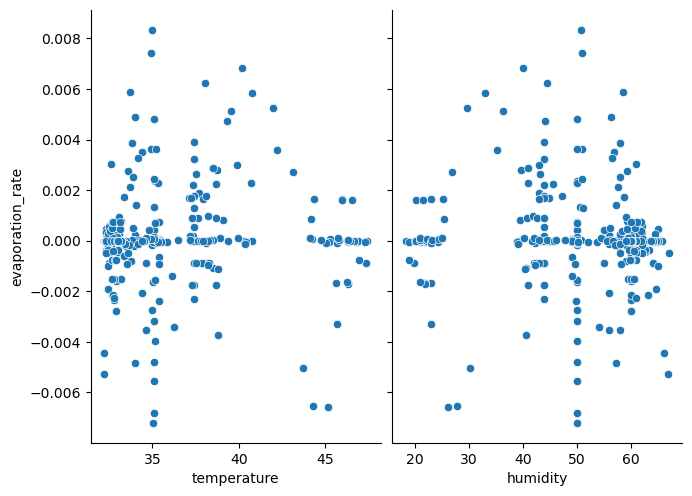

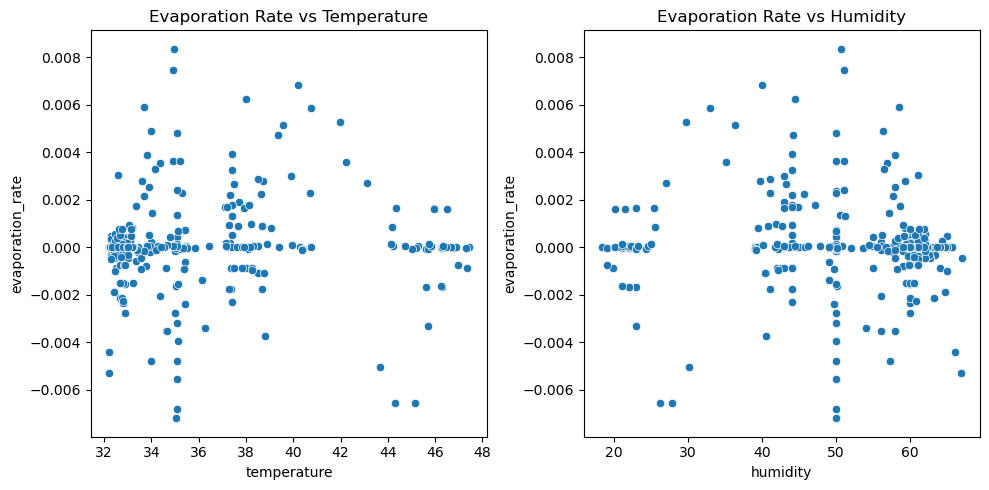

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pairplot to visualize relationships
sns.pairplot(df_filtered, x_vars=['temperature', 'humidity'], y_vars='evaporation_rate', height=5, aspect=0.7)
plt.show()

# Scatter plot for detailed analysis
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='temperature', y='evaporation_rate', data=df_filtered)
plt.title('Evaporation Rate vs Temperature')

plt.subplot(1, 2, 2)
sns.scatterplot(x='humidity', y='evaporation_rate', data=df_filtered)
plt.title('Evaporation Rate vs Humidity')

plt.tight_layout()
plt.show()


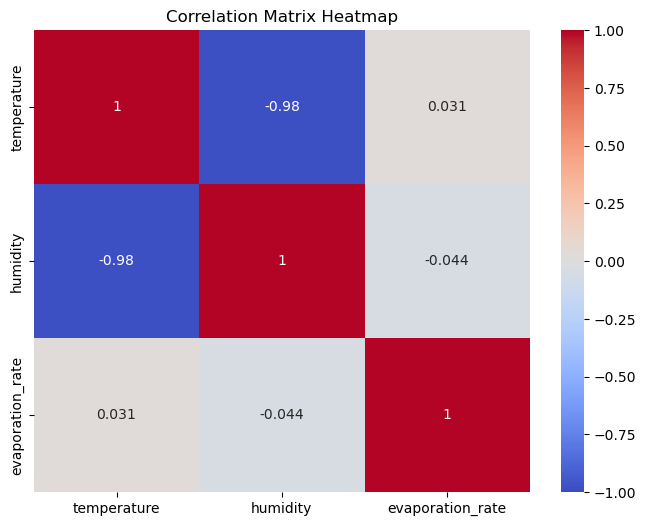

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = df_filtered[['temperature', 'humidity', 'evaporation_rate']].corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)

# Add titles and labels
plt.title('Correlation Matrix Heatmap')
plt.show()


In [19]:
### Train Test split

import numpy as np
train_data, test_data = np.split(df_filtered.sample(frac=1, random_state=1729), [int(0.7 * len(df_filtered))])
print(train_data.shape, test_data.shape)

(230, 6) (100, 6)


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [20]:
### Saving Train And Test Into Buckets
## We start with Train Data
import os
pd.concat([train_data['evaporation_rate'], train_data.drop(['evaporation_rate'], 
                                                axis=1)], 
                                                axis=1).to_csv('train.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

In [21]:
# Test Data Into Buckets
pd.concat([test_data['evaporation_rate'], test_data.drop(['evaporation_rate'], axis=1)], axis=1).to_csv('test.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
s3_input_test = sagemaker.TrainingInput(s3_data='s3://{}/{}/test'.format(bucket_name, prefix), content_type='csv')

### Building Models Xgboot- Inbuilt Algorithm

In [22]:
from sagemaker.amazon.amazon_estimator import get_image_uri 

In [23]:
# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
# specify the repo_version depending on your preference.
container = get_image_uri(boto3.Session().region_name,
                          'xgboost', 
                          repo_version='1.0-1')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [24]:
# initialize hyperparameters
hyperparameters = {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "objective":"reg:squarederror",
        "num_round":50
        }

In [25]:
# construct a SageMaker estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(image_uri=container, 
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          train_instance_count=1, 
                                          train_instance_type='ml.m5.2xlarge', 
                                          train_volume_size=5, # 5 GB 
                                          output_path=output_path,
                                          train_use_spot_instances=True,
                                          train_max_run=300,
                                          train_max_wait=600)
     

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_use_spot_instances has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_wait has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [26]:
estimator.fit({'train': s3_input_train,'validation': s3_input_test})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-05-19-00-23-02-789


2024-05-19 00:23:02 Starting - Starting the training job...
2024-05-19 00:23:18 Starting - Preparing the instances for training...
2024-05-19 00:23:45 Downloading - Downloading input data...
2024-05-19 00:24:25 Training - Training image download completed. Training in progress....
2024-05-19 00:25:03 Uploading - Uploading generated training model
2024-05-19 00:25:03 Completed - Training job completed
[2024-05-19 00:24:46.562 ip-10-0-66-73.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determine

In [27]:
xgb_predictor = estimator.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-05-19-00-26-00-517
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-05-19-00-26-00-517
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-05-19-00-26-00-517


-----!

In [57]:
xgb_predictor

In [28]:
from sagemaker.serializers import CSVSerializer

test_data_array = test_data.drop(['evaporation_rate'], axis=1).values #load the data into an array
xgb_predictor.content_type = 'text/csv' # set the data type for an inference
xgb_predictor.serializer = CSVSerializer() # set the serializer type
predictions = xgb_predictor.predict(test_data_array).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array
print(predictions_array.shape)

(100,)


In [29]:
from sagemaker.serializers import CSVSerializer
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the test data
test_data_array = test_data.drop(['evaporation_rate'], axis=1).values  # Drop the target column

# Configure the predictor
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = CSVSerializer()

# Make predictions
predictions = xgb_predictor.predict(test_data_array).decode('utf-8')

# Convert predictions to an array
predictions_array = np.fromstring(predictions, sep=',')

# Print the shape of the predictions array
print(predictions_array.shape)

# Evaluate the model
mse = mean_squared_error(test_data['evaporation_rate'], predictions_array)
r2 = r2_score(test_data['evaporation_rate'], predictions_array)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


(100,)
Mean Squared Error: 3.01460380073101e-06
R² Score: -0.0010847531541320343


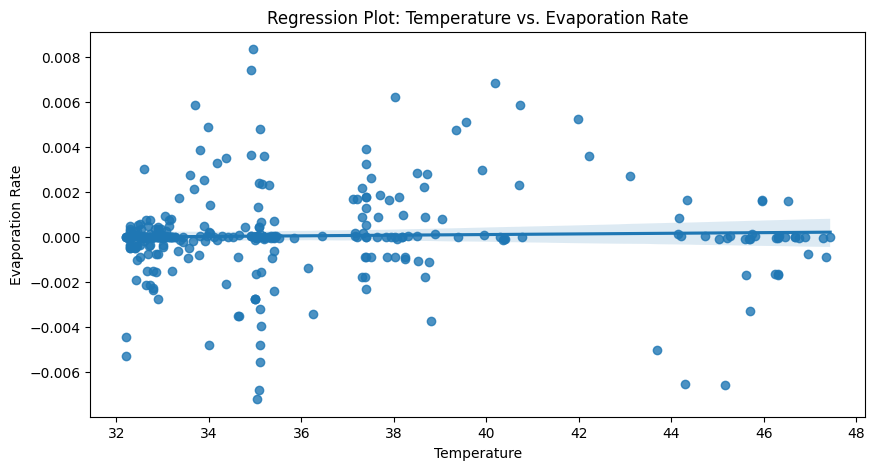

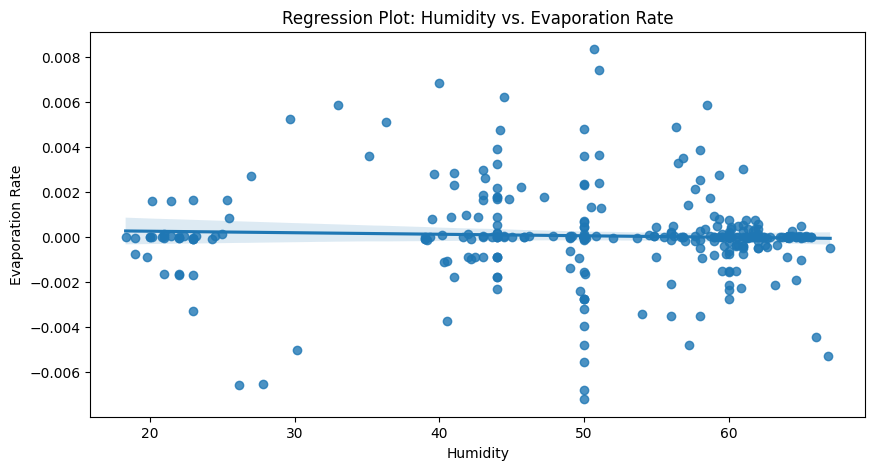

In [356]:
import seaborn as sns
import matplotlib.pyplot as plt

# Regression plot for temperature vs. evaporation rate
plt.figure(figsize=(10, 5))
sns.regplot(x='temperature', y='evaporation_rate', data=df_filtered)
plt.title('Regression Plot: Temperature vs. Evaporation Rate')
plt.xlabel('Temperature')
plt.ylabel('Evaporation Rate')
plt.show()


# Regression plot for humidity vs. evaporation rate
plt.figure(figsize=(10, 5))
sns.regplot(x='humidity', y='evaporation_rate', data=df_filtered)
plt.title('Regression Plot: Humidity vs. Evaporation Rate')
plt.xlabel('Humidity')
plt.ylabel('Evaporation Rate')
plt.show()


### Decision Tree

Threshold: 0.05
0    330
Name: irrigation_needed, dtype: int64
Threshold: 0.01
0    330
Name: irrigation_needed, dtype: int64
Threshold: 0.005
0    322
1      8
Name: irrigation_needed, dtype: int64
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        71
           1       1.00      1.00      1.00        58

    accuracy                           1.00       129
   macro avg       1.00      1.00      1.00       129
weighted avg       1.00      1.00      1.00       129



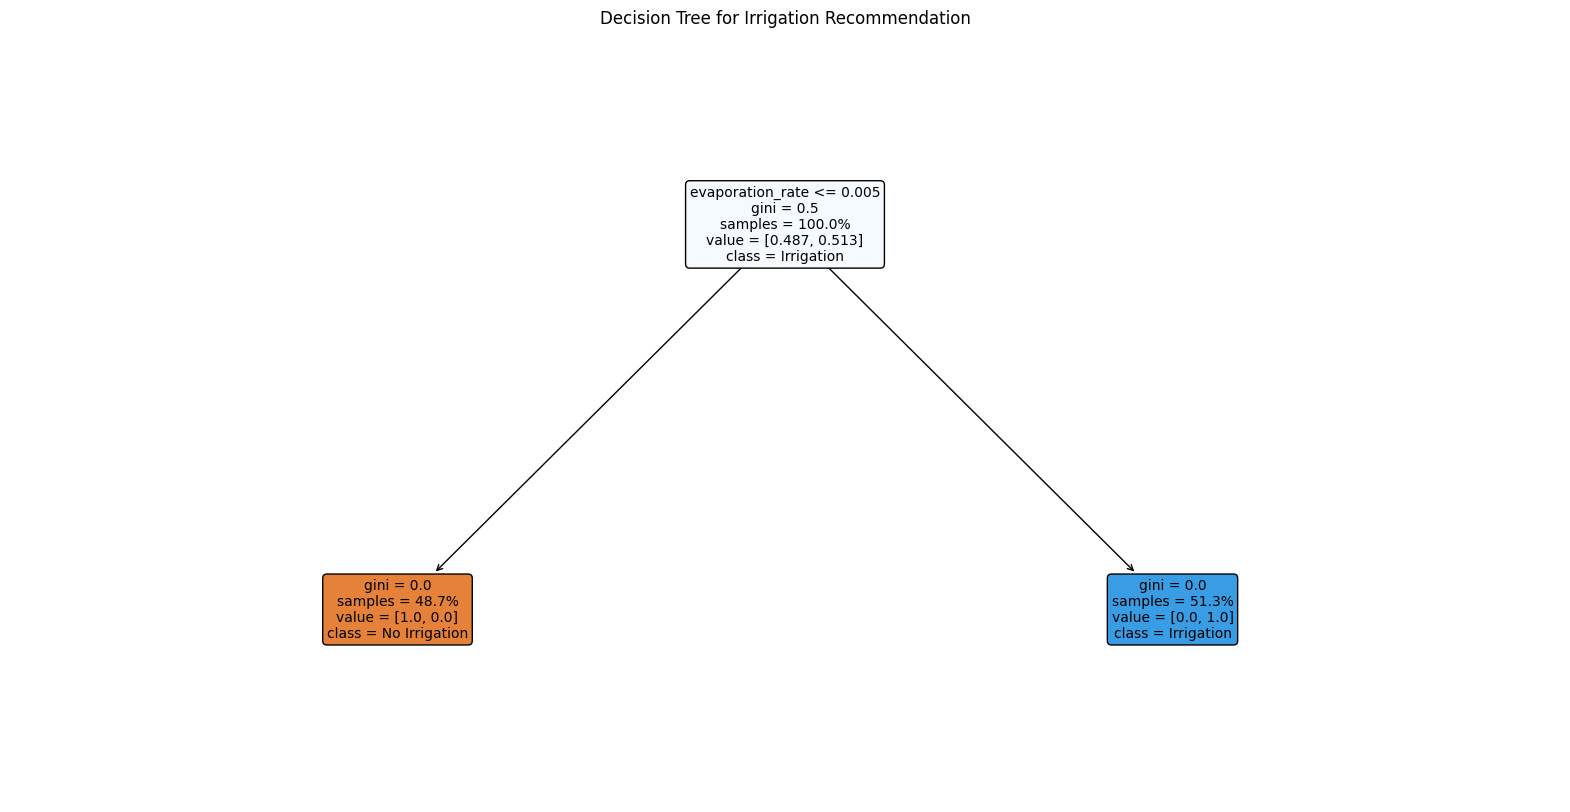

Irrigation is recommended.


In [403]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn import tree


df_filtered = df_filtered.copy()

# Try different thresholds to achieve class balance
thresholds = [0.05, 0.01, 0.005, 0.001]  # Adjust these thresholds as needed

for evaporation_threshold in thresholds:
    df_filtered['irrigation_needed'] = (df_filtered['evaporation_rate'] > evaporation_threshold).astype(int)
    print(f"Threshold: {evaporation_threshold}")
    print(df_filtered['irrigation_needed'].value_counts())
    if df_filtered['irrigation_needed'].nunique() > 1:
        break

# Verify class distribution after threshold adjustment
if df_filtered['irrigation_needed'].nunique() <= 1:
    print("Insufficient class diversity in the target variable. Adjust the threshold or verify the data.")
else:
    # Prepare features and target
    X = df_filtered[['temperature', 'humidity', 'evaporation_rate']]
    y = df_filtered['irrigation_needed']

    # Use SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Split the resampled data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

    # Initialize and train the Decision Tree model
    model = DecisionTreeClassifier(random_state=42, max_depth=3, min_samples_split=10, min_samples_leaf=5)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))

    # Visualize the Decision Tree
    plt.figure(figsize=(20,10))
    tree.plot_tree(model, 
                   feature_names=['temperature', 'humidity', 'evaporation_rate'], 
                   class_names=['No Irrigation', 'Irrigation'], 
                   filled=True, 
                   rounded=True, 
                   proportion=True, 
                   fontsize=10)
    plt.title('Decision Tree for Irrigation Recommendation')
    plt.show()

    # Example of making a recommendation
    new_data = pd.DataFrame({
        'temperature': [35.0],  # Replace with actual data
        'humidity': [50.0],     # Replace with actual data
        'evaporation_rate': [0.12]  # Replace with actual data
    })

    irrigation_prediction = model.predict(new_data)
    if irrigation_prediction[0] == 1:
        print("Irrigation is recommended.")
    else:
        print("No irrigation needed at this time.")

# Approach 2
## Cross Section Analysis

Evaporimeter Reading

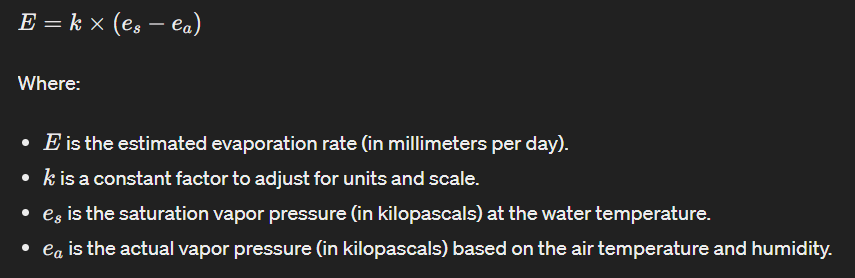

In [366]:
df_cs=df
df_cs['timestamp'] = pd.to_datetime(df_cs['timestamp'])
df_cs = df_cs[df_cs['timestamp'].dt.year != 1970]
df_cs = df_cs.sort_values(by='timestamp')
df_cs.head()

,humidity,distance,temperature,timestamp
3,51,3.689,35.0,2024-05-01 14:20:06+00:00
4,51,3.281,35.0,2024-05-01 14:20:07+00:00
5,51,4.573,35.0,2024-05-01 14:20:08+00:00
6,51,4.573,35.0,2024-05-01 14:20:09+00:00
7,51,3.264,35.0,2024-05-01 14:20:10+00:00


In [367]:
df_cs=df_cs.drop(columns=["timestamp"])
df_cs.head()

,humidity,distance,temperature
3,51,3.689,35.0
4,51,3.281,35.0
5,51,4.573,35.0
6,51,4.573,35.0
7,51,3.264,35.0


In [368]:
k = 0.1  # Adjust this constant as needed for scaling

# Function to calculate estimated evaporation rate
def estimate_evaporation(row):
    # Constants for vapor pressure calculation
    a = 17.27
    b = 237.3
    
    # Calculate saturation vapor pressure (es)
    es = 0.611 * pow(2.71828, (a * row['temperature']) / (row['temperature'] + b))
    
    # Calculate actual vapor pressure (ea)
    ea = es * (row['humidity'] / 100)
    
    # Calculate estimated evaporation rate
    return k * (es - ea)

# Apply function to each row to calculate estimated evaporation rate
df_cs['estimated_evaporation'] = df_cs.apply(estimate_evaporation, axis=1)

# Display DataFrame with estimated evaporation rates
df_cs.head()

,humidity,distance,temperature,estimated_evaporation
3,51,3.689,35.0,0.275601
4,51,3.281,35.0,0.275601
5,51,4.573,35.0,0.275601
6,51,4.573,35.0,0.275601
7,51,3.264,35.0,0.275601


In [370]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split data into features (X) and target (y)
X = df_cs[['humidity', 'distance', 'temperature']]
y = df_cs['estimated_evaporation']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on testing set
y_pred = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.000612183857677236


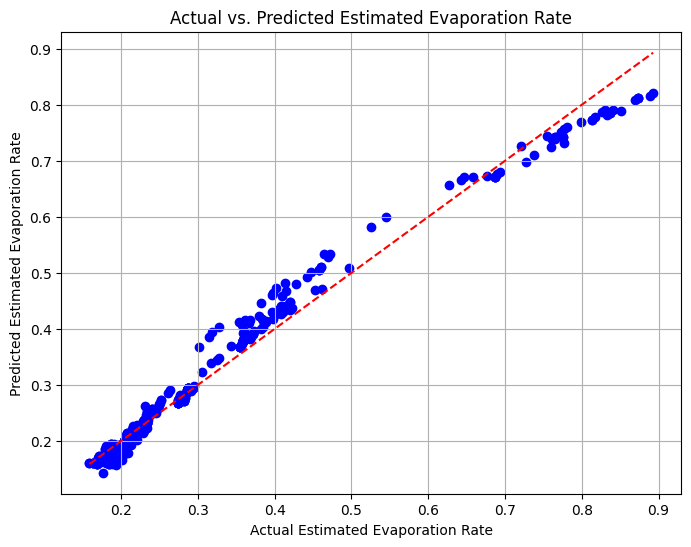

In [371]:
import matplotlib.pyplot as plt

# Plot the actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Estimated Evaporation Rate')
plt.ylabel('Predicted Estimated Evaporation Rate')
plt.title('Actual vs. Predicted Estimated Evaporation Rate')
plt.grid(True)
plt.show()


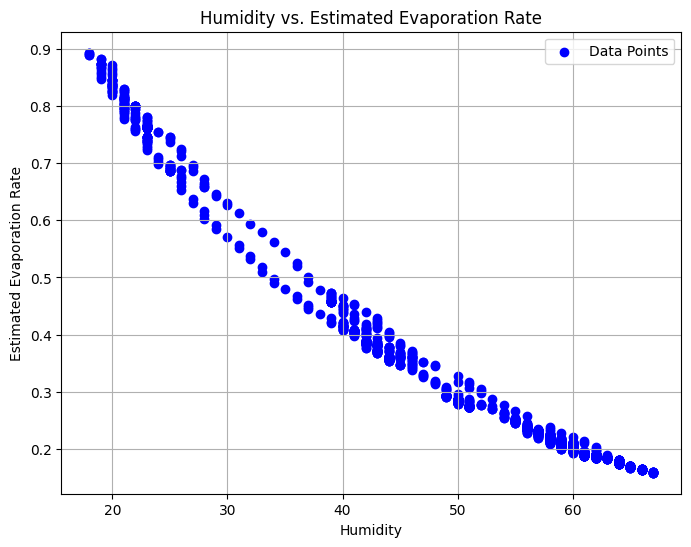

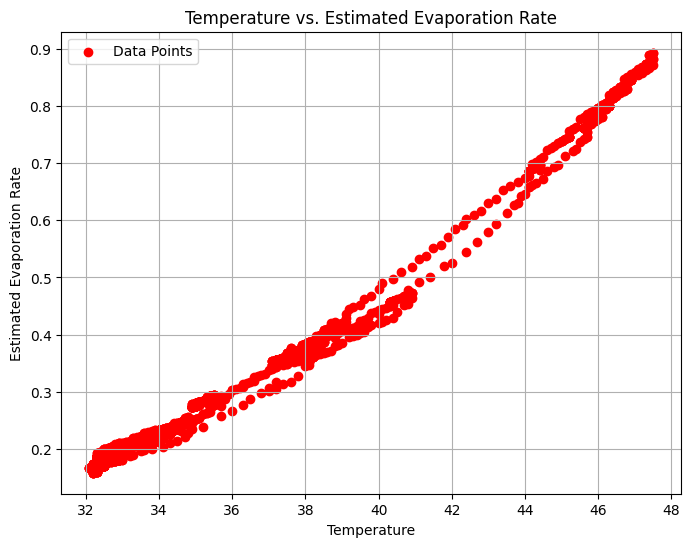

In [372]:
import matplotlib.pyplot as plt

# Create scatter plot for Humidity vs. Estimated Evaporation Rate
plt.figure(figsize=(8, 6))
plt.scatter(df_cs['humidity'], df_cs['estimated_evaporation'], color='blue', label='Data Points')
plt.xlabel('Humidity')
plt.ylabel('Estimated Evaporation Rate')
plt.title('Humidity vs. Estimated Evaporation Rate')
plt.legend()
plt.grid(True)
plt.show()


# Create scatter plot for Temperature vs. Estimated Evaporation Rate
plt.figure(figsize=(8, 6))
plt.scatter(df_cs['temperature'], df_cs['estimated_evaporation'], color='red', label='Data Points')
plt.xlabel('Temperature')
plt.ylabel('Estimated Evaporation Rate')
plt.title('Temperature vs. Estimated Evaporation Rate')
plt.legend()
plt.grid(True)
plt.show()


In [373]:
# Calculate Pearson correlation coefficient
correlation = df_cs['humidity'].corr(df_cs['estimated_evaporation'])

print("Pearson Correlation Coefficient between Humidity and Estimated Evaporation Rate:", correlation)

# Calculate Pearson correlation coefficient
correlation = df_cs['temperature'].corr(df_cs['estimated_evaporation'])

print("Pearson Correlation Coefficient between Temperatire and Estimated Evaporation Rate:", correlation)


Pearson Correlation Coefficient between Humidity and Estimated Evaporation Rate: -0.9743225626482532
Pearson Correlation Coefficient between Temperatire and Estimated Evaporation Rate: 0.9912619221528399


We can see negative correlation between humidity and evaporation meter. While there is a positive correlation between temperature and evaporation meter.

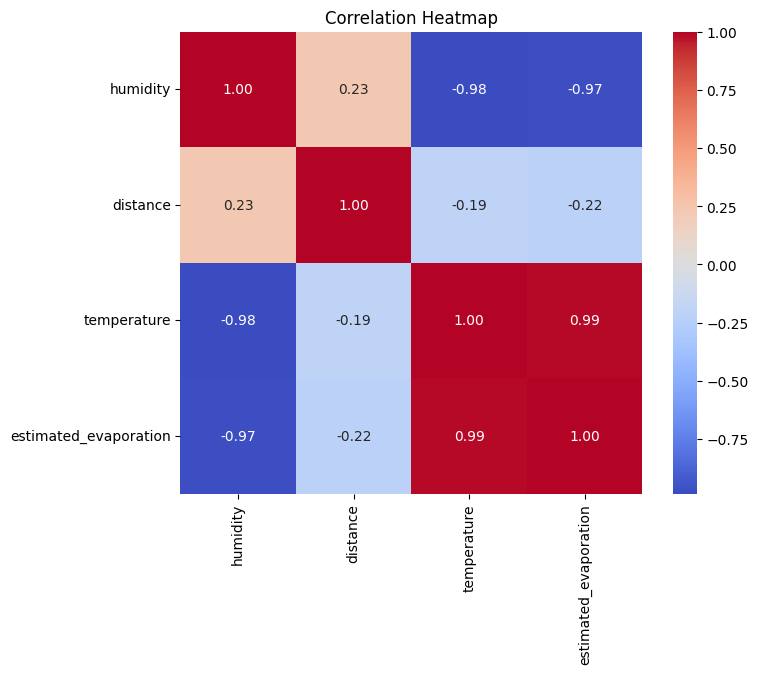

In [380]:
# Compute correlation matrix
correlation_matrix = df_cs[['humidity', 'distance', 'temperature', 'estimated_evaporation']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap')
plt.show()


Threshold: 0.2
1    1353
0     555
Name: irrigation_needed, dtype: int64
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       265
           1       1.00      1.00      1.00       277

    accuracy                           1.00       542
   macro avg       1.00      1.00      1.00       542
weighted avg       1.00      1.00      1.00       542



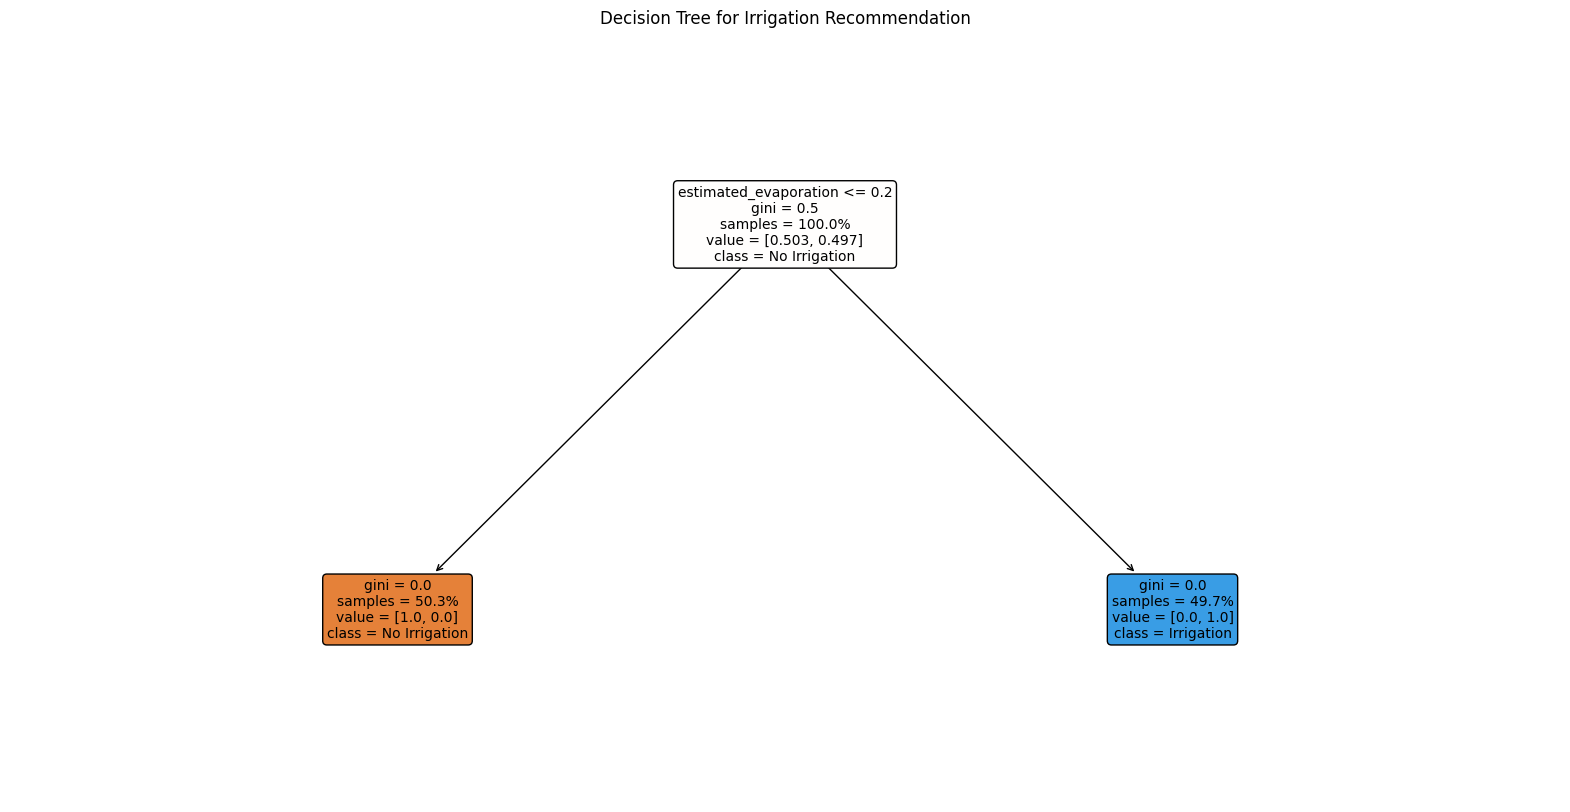

No irrigation needed at this time.


In [408]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn import tree


df_cs = df_cs.copy()

# Try different thresholds to achieve class balance
thresholds = [0.2]  # Adjust these thresholds as needed

for evaporation_threshold in thresholds:
    df_cs['irrigation_needed'] = (df_cs['estimated_evaporation'] > evaporation_threshold).astype(int)
    print(f"Threshold: {evaporation_threshold}")
    print(df_cs['irrigation_needed'].value_counts())
    if df_filtered['irrigation_needed'].nunique() > 1:
        break

# Verify class distribution after threshold adjustment
if df_cs['irrigation_needed'].nunique() <= 1:
    print("Insufficient class diversity in the target variable. Adjust the threshold or verify the data.")
else:
    # Prepare features and target
    X = df_cs[['temperature', 'humidity', 'estimated_evaporation']]
    y = df_cs['irrigation_needed']

    # Use SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Split the resampled data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

    # Initialize and train the Decision Tree model
    model = DecisionTreeClassifier(random_state=42, max_depth=3, min_samples_split=10, min_samples_leaf=5)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))

    # Visualize the Decision Tree
    plt.figure(figsize=(20,10))
    tree.plot_tree(model, 
                   feature_names=['temperature', 'humidity', 'estimated_evaporation'], 
                   class_names=['No Irrigation', 'Irrigation'], 
                   filled=True, 
                   rounded=True, 
                   proportion=True, 
                   fontsize=10)
    plt.title('Decision Tree for Irrigation Recommendation')
    plt.show()

    # Example of making a recommendation
    new_data = pd.DataFrame({
        'temperature': [35.0],  # Replace with actual data
        'humidity': [50.0],     # Replace with actual data
        'estimated_evaporation': [0.12]  # Replace with actual data
    })

    irrigation_prediction = model.predict(new_data)
    if irrigation_prediction[0] == 1:
        print("Irrigation is recommended.")
    else:
        print("No irrigation needed at this time.")


# Time Series Analysis

In [31]:
# Convert 'timestamp' column to DateTime data type
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract date and time components
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

In [33]:
k = 0.1  # Adjust this constant as needed for scaling

# Function to calculate estimated evaporation rate
def estimate_evaporation(row):
    # Constants for vapor pressure calculation
    a = 17.27
    b = 237.3
    
    # Calculate saturation vapor pressure (es)
    es = 0.611 * pow(2.71828, (a * row['temperature']) / (row['temperature'] + b))
    
    # Calculate actual vapor pressure (ea)
    ea = es * (row['humidity'] / 100)
    
    # Calculate estimated evaporation rate
    return k * (es - ea)

# Apply function to each row to calculate estimated evaporation rate
df['estimated_evaporation'] = df.apply(estimate_evaporation, axis=1)


In [34]:
df.head()

,humidity,distance,temperature,timestamp,date,hour,day_of_week,month,estimated_evaporation
0,23,3.196,46.099998,2024-05-01 14:58:54+00:00,2024-05-01,14,2,5,0.780875
1,21,3.196,46.400002,2024-05-01 15:08:14+00:00,2024-05-01,15,2,5,0.813502
2,20,3.196,46.599998,2024-05-01 15:07:29+00:00,2024-05-01,15,2,5,0.832226
3,50,3.689,35.099998,2024-05-01 14:21:34+00:00,2024-05-01,14,2,5,0.282784
4,21,3.196,46.200001,2024-05-01 15:04:12+00:00,2024-05-01,15,2,5,0.805254


In [36]:
df = df[df['timestamp'].dt.year != 1970]

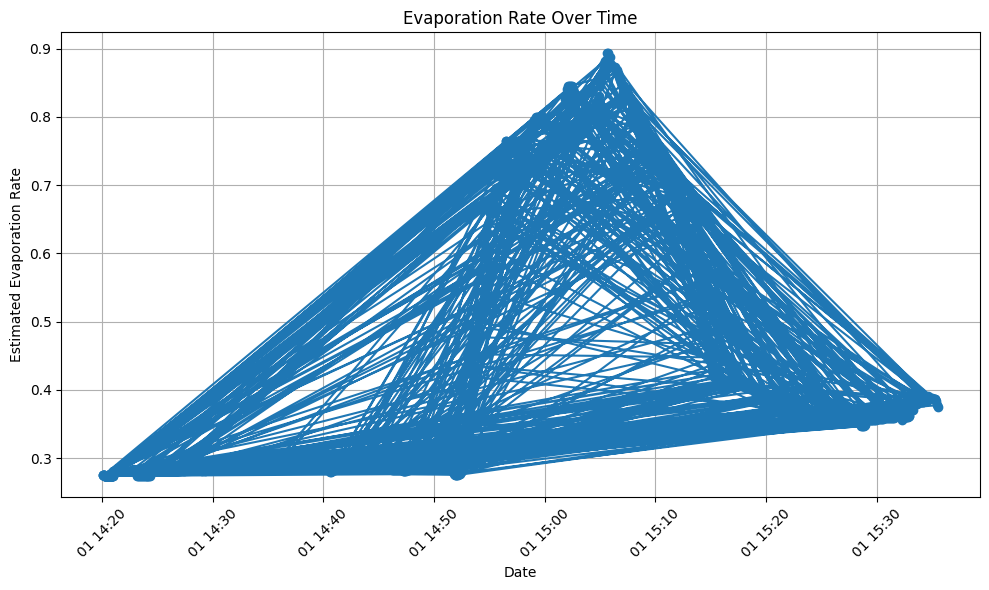

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['estimated_evaporation'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Estimated Evaporation Rate')
plt.title('Evaporation Rate Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

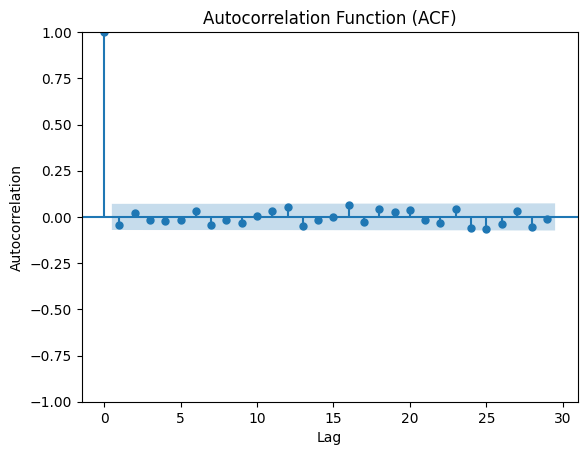

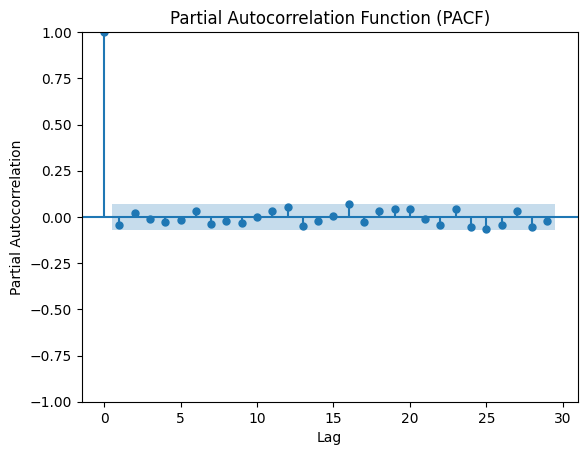

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plot_acf(df['estimated_evaporation'])
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plot_pacf(df['estimated_evaporation'])
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()
